In [1]:
# var inspector (install in anaconda prompt):
#   conda install -c conda-forge jupyterlab-variableinspector

In [1]:
# %conda install tensorflow
# %conda install tensorflow-gpu
# %conda install numpy
# %conda install pandas
# %conda install -c conda-forge matplotlib
# %conda install keras
# %conda install Pillow

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Pikam\anaconda3\envs\tfgpu

  added / updated specs:
    - matplotlib


The following NEW packages will be INSTALLED:

  brotli             conda-forge/win-64::brotli-1.0.9-h8ffe710_7
  brotli-bin         conda-forge/win-64::brotli-bin-1.0.9-h8ffe710_7
  cycler             conda-forge/noarch::cycler-0.11.0-pyhd8ed1ab_0
  fonttools          conda-forge/win-64::fonttools-4.33.3-py39hb82d6ee_0
  freetype           conda-forge/win-64::freetype-2.10.4-h546665d_1
  kiwisolver         conda-forge/win-64::kiwisolver-1.4.2-py39h2e07f2f_1
  libbrotlicommon    conda-forge/win-64::libbrotlicommon-1.0.9-h8ffe710_7
  libbrotlidec       conda-forge/win-64::libbrotlidec-1.0.9-h8ffe710_7
  libbrotlienc       conda-forge/win-64::libbrotlienc-1.0.9-h8ffe710_7
  

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10190679645430315889,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5767102464
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15318400150341563928
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [3]:
tf.debugging.set_log_device_placement(False)

In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [4]:
# image size: 1080*1920
INPUT_HEIGHT = 216
INPUT_WIDTH = 384
INPUT_CHANNEL = 3
INPUT_SHAPE = (INPUT_HEIGHT,INPUT_WIDTH,INPUT_CHANNEL)

OUTPUT_HEIGHT = INPUT_HEIGHT
OUTPUT_WIDTH = INPUT_WIDTH
OUTPUT_CHANNEL = INPUT_CHANNEL
OUTPUT_SHAPE = INPUT_SHAPE

In [8]:
import glob
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# FIXME: tf.data.Dataset maybe faster
# e.g. dir_name = 'data/stimuli.out/'
def x_from_dir(dir_name):
    x_paths = glob.glob(dir_name + '*.jpg', recursive=False)[:1000]
    
    # initialize
    first_img = load_img(x_paths[0], target_size=(INPUT_HEIGHT, INPUT_WIDTH))
    x = img_to_array(first_img).reshape(1,INPUT_HEIGHT,INPUT_WIDTH,INPUT_CHANNEL)
    # remaining
    for path in x_paths[1:]:
        img = load_img(path, target_size=(INPUT_HEIGHT, INPUT_WIDTH))
        arr = img_to_array(img).reshape(1,INPUT_HEIGHT,INPUT_WIDTH, INPUT_CHANNEL)
        x = np.append(x, arr, axis=0)

    return x / 255

# FIXME: tf.data.Dataset maybe faster
# e.g. dir_name = 'data/heatmap/'
def y_from_dir(dir_name):
    y_paths = glob.glob(dir_name + '*_heatmap.png', recursive=False)
    
    # initialize
    first_img = load_img(y_paths[0], color_mode='grayscale', target_size=(OUTPUT_HEIGHT, OUTPUT_WIDTH))
    y = img_to_array(first_img).reshape(1,OUTPUT_HEIGHT,OUTPUT_WIDTH,1)
    # remaining
    for path in y_paths[1:]:
        img = load_img(path, color_mode='grayscale', target_size=(OUTPUT_HEIGHT, OUTPUT_WIDTH))
        arr = img_to_array(img).reshape(1,OUTPUT_HEIGHT,OUTPUT_WIDTH,1)
        y = np.append(y, arr, axis=0)

    return y / 256

def salicon_y_from_dir(dir_name):
    y_paths = glob.glob(dir_name + '*.png', recursive=False)[:1000]
    
    # initialize
    first_img = load_img(y_paths[0], color_mode='grayscale', target_size=(OUTPUT_HEIGHT, OUTPUT_WIDTH))
    y = img_to_array(first_img).reshape(1,OUTPUT_HEIGHT,OUTPUT_WIDTH,1)
    # remaining
    for path in y_paths[1:]:
        img = load_img(path, color_mode='grayscale', target_size=(OUTPUT_HEIGHT, OUTPUT_WIDTH))
        arr = img_to_array(img).reshape(1,OUTPUT_HEIGHT,OUTPUT_WIDTH,1)
        y = np.append(y, arr, axis=0)

    return y / 256

In [6]:
# https://jpn.pioneer/ja/strengths/crdl/rd/pdf/2020-1.pdf
from tensorflow.keras import datasets, layers, models

model = models.Sequential()

model.add(layers.Conv2D(64, (7, 7), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
# 5*5 dilated convolution?
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (7, 7), activation='relu', padding='same'))
model.add(layers.Conv2D(1, (7, 7), activation='relu', padding='same'))

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 216, 384, 64)      9472      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 384, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 192, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 192, 128)     204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 192, 128)     409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 96, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 54, 96, 256)       2

In [9]:
# salicon dataset
salicon_x_dir = 'data/salicon_images/'
salicon_x = x_from_dir(salicon_x_dir)
salicon_y_dir = 'data/salicon_heatmap/'
salicon_y = salicon_y_from_dir(salicon_y_dir)

In [10]:
x_dir = 'data/stimuli.out/'
x = x_from_dir(x_dir)
y_dir = 'data/heatmap/'
y = y_from_dir(y_dir)

In [11]:
# slice all data
TRAIN_SIZE = 270
x_train = x[:TRAIN_SIZE]
x_test = x[TRAIN_SIZE:]
y_train = y[:TRAIN_SIZE]
y_test = y[TRAIN_SIZE:]

x_train_with_salicon = np.append(x_train, salicon_x, axis=0)
y_train_with_salicon = np.append(y_train, salicon_y, axis=0)

In [14]:
model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
27/27 [==============================] - 38s 449ms/step - loss: 14.1197 - accuracy: 0.0255
Epoch 2/10
27/27 [==============================] - 12s 449ms/step - loss: 14.6444 - accuracy: 0.0000e+00
Epoch 3/10
27/27 [==============================] - 12s 456ms/step - loss: 14.6444 - accuracy: 0.0000e+00
Epoch 4/10
27/27 [==============================] - 12s 451ms/step - loss: 14.6444 - accuracy: 0.0000e+00
Epoch 5/10
27/27 [==============================] - 12s 445ms/step - loss: 14.6444 - accuracy: 0.0000e+00
Epoch 6/10
27/27 [==============================] - 12s 445ms/step - loss: 14.6444 - accuracy: 0.0000e+00
Epoch 7/10
27/27 [==============================] - 12s 445ms/step - loss: 14.6444 - accuracy: 0.0000e+00
Epoch 8/10
27/27 [==============================] - 12s 446ms/step - loss: 14.6444 - accuracy: 0.0000e+00
Epoch 9/10
27/27 [==============================] - 12s 445ms/step - loss: 14.6444 - accuracy: 0.0000e+00
Epoch 10/10
27/27 [==============================]

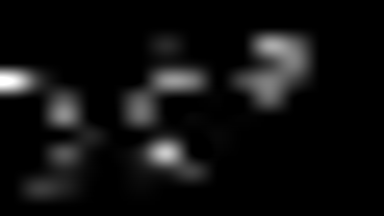

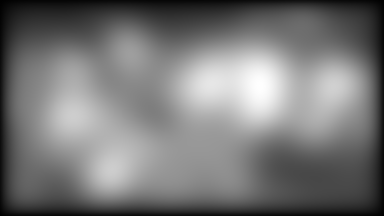

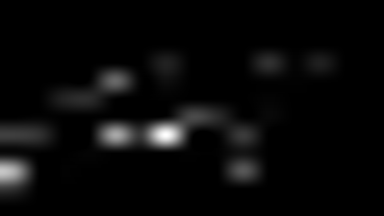

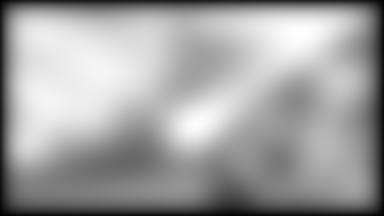

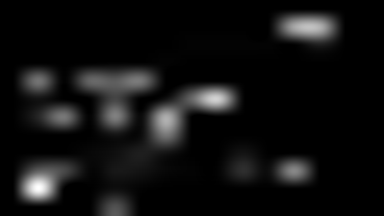

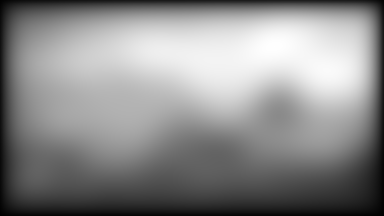

In [15]:
from tensorflow.keras.utils import array_to_img
y_pred = model.predict(x_test)
for i in range(6,9):
    pred_img = array_to_img(y_pred[i])
    display(array_to_img(y_test[i]))
    display(pred_img)

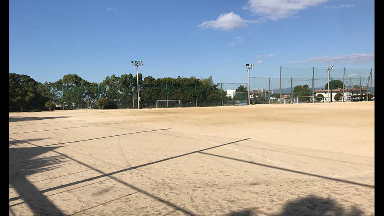

In [21]:
import numpy as np

#csvファイルとして保存
# [:1000]
np.savetxt('out.csv', salicon_x, delimiter=',')
np.savetxt('out.csv', salicon_y, delimiter=',')